# Multiclass classification with ResNet50

In this notebook we will again try multiclass classification but this time using our own implementation of Residual Networks (`ResNet`). More specifically we will use the `ResNet50` model architecture.

In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from residual_network import ResNet50

## Load data

We start by loading the `Fashion MNIST` dataset we used in a previous exercise.

In [2]:
# Split
split = ['train[:15%]', 'test[:10%]', 'test[10%:20%]']

# Load data
(ds_train, ds_eval, ds_test), ds_info = tfds.load(
    name='fashion_mnist',
    split=split,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

## Inspect dataset

We inspect our data to get a sense of what the images and labels look like

In [3]:
len(ds_train)

9000

In [4]:
# Print info
print(len(ds_train))
print(len(ds_eval))
print(len(ds_test))
print(ds_train.element_spec)

# Calculate number of classes
num_classes = ds_info.features['label'].num_classes
print(num_classes)

9000
1000
1000
(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
10


In [5]:
img_input_shape = (28, 28, 1)
img_n_classes = 10

We visualize some of the images in our training dataset.

2023-07-24 18:22:26.354867: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-07-24 18:22:26.356548: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


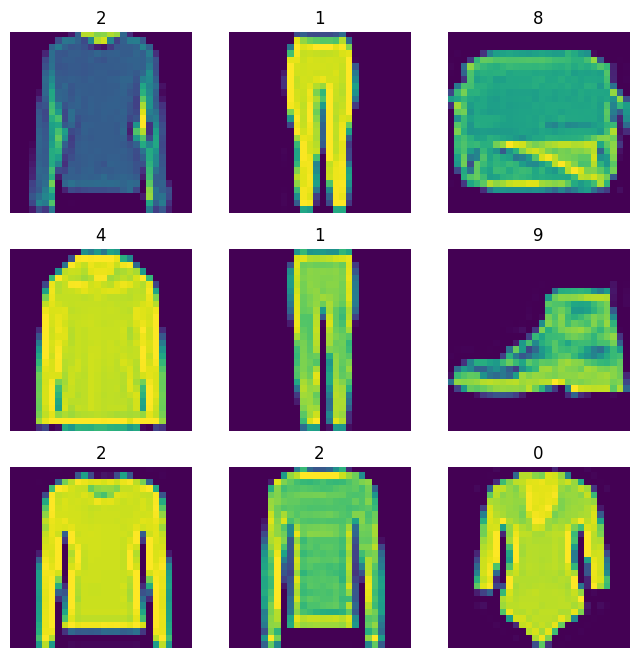

In [6]:
images_iter = iter(x_train for x_train, _ in ds_train.take(9).cache().repeat())
labels_iter = iter(y_train for _, y_train in ds_train.take(9).cache().repeat())
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(next(images_iter).numpy().astype('uint8'))
    plt.title(next(labels_iter).numpy().astype('uint8'))
    plt.axis('off')

## Preprocess data

We preprocess our data

In [7]:
def normalize(image, label):
    """Normalize image pixels."""
    return tf.cast(image, tf.float32) / 255.0, label

In [8]:
# Normalize data
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_eval = ds_eval.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
# Element spec after normalization
print(ds_train.element_spec)

(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


### Set up data for training and evaluation

The `Dataset` API has some nice functionalities for speeding up the traning time.

By caching the datasets we we will save some operations (like file opening and data reading) from being executed during each epoch, [reference](https://www.tensorflow.org/guide/data_performance#caching).

First, we take the training data and apply the following steps:
* cache it before shuffling for better performance
* for true randomness, set shuffle buffer to full dataset size
* batch elements of the dataset after shuffling to get unique batches at each epoch
* prefetch to increase performace

In [10]:
# Cache train data
ds_train = ds_train.cache()

# Shuffle data for true randomness and to reduce memory usage
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)

# Set batch size
ds_train = ds_train.batch(64)

# Prefetch
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

Second, we take our evaluation and test data. We do similar steps but skip a few:

* we don't shuffle the data
* caching is done after batching because batches can be the same between epochs

In [11]:
# Set batch size
ds_eval = ds_eval.batch(64)
ds_test = ds_test.batch(64)

# Cache data
ds_eval = ds_eval.cache()
ds_test = ds_test.cache()

# Prefetch
ds_eval = ds_eval.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Train model

We instantiate the model and let it train for 1 epoch.

In [14]:
clf = ResNet50(input_shape=img_input_shape, classes=img_n_classes)

In [15]:
# Train model
clf.call(ds_train=ds_train, ds_eval=ds_eval, epochs=1)

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 34, 34, 1)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 14, 14, 64)           3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 14, 14, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                         

/home/hojve/repos/github/deep-learning/deep-learning-fundamentals/.venv/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


141/141 [==============================] - 358s 2s/step - loss: 0.9753 - accuracy: 0.6879 - val_loss: 0.6613 - val_accuracy: 0.7680


### Test errors

We evaluate the model on our test dataset.

In [16]:
clf.evaluate(ds_test=ds_test)

16/16 [==============================] - 2s 101ms/step - loss: 0.6658 - accuracy: 0.7770
